In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing

In [2]:
print(cv2.getBuildInformation())


General configuration for OpenCV 4.6.0 =====================================
  Version control:               unknown

  Extra modules:
    Location (extra):            C:/b/abs_d8ltn27ay8/croot/opencv-suite_1676452046667/work/opencv_contrib-4.6.0/modules
    Version control (extra):     unknown

  Platform:
    Timestamp:                   2023-02-15T12:02:59Z
    Host:                        Windows 10.0.17763 AMD64
    CMake:                       3.22.1
    CMake generator:             Ninja
    CMake build tool:            C:/b/abs_d8ltn27ay8/croot/opencv-suite_1676452046667/_build_env/Library/bin/ninja.exe
    MSVC:                        1916
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
   

In [3]:
def process_frame(frame, shared_frames):
    # Convert the frame to grayscale if it's not already
    if len(frame.shape) == 3:  # Color image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    shared_frames.append(frame)

def load_and_convert_movie_mp(filename):
    cap = cv2.VideoCapture(filename)
    
    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    manager = multiprocessing.Manager()
    frames = manager.list()  # Use Manager.list() for shared list among processes
    
    with tqdm(total=total_frames, desc='Loading Movie', unit='frame') as pbar:
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
            
            # Process the frame in a separate process
            process = multiprocessing.Process(target=process_frame, args=(frame, frames))
            process.start()
            process.join()
            
            pbar.update(1)
    
    cap.release()
    return list(frames)  # Convert Manager.list() to a regular list

In [33]:
def load_and_convert_movie(filename):
    cap = cv2.VideoCapture(filename)
    
    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    
    with tqdm(total=total_frames, desc='Loading Movie', unit='frame') as pbar:
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
            
            # Convert the frame to grayscale if it's not already
            if len(frame.shape) == 3:  # Color image
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            frames.append(frame)
            pbar.update(1)
    
    cap.release()
    return frames

def auto_contrast_adjustment(frames, saturation_threshold=0.35):
    adjusted_frames = []
    
    with tqdm(total=len(frames), desc='Processing Frames', unit='frame') as pbar:
        for frame in frames:
            # Perform auto contrast adjustment using the specified saturation threshold
            min_val = np.percentile(frame, saturation_threshold * 100)
            max_val = np.percentile(frame, (1 - saturation_threshold) * 100)
            adjusted_frame = np.clip(frame, min_val, max_val)
            
            # Scale the pixel values to the full dynamic range (0-255)
            adjusted_frame = ((adjusted_frame - min_val) / (max_val - min_val)) * 255
            
            # Convert the pixel values to uint8 data type
            adjusted_frame = adjusted_frame.astype(np.uint8)
            
            adjusted_frames.append(adjusted_frame)
            pbar.update(1)
    
    return adjusted_frames


def auto_contrast_adjustment_eqhist(frames):
    adjusted_frames = []
    
    with tqdm(total=len(frames), desc='Processing Frames', unit='frame') as pbar:
        for frame in frames:
            # Apply histogram equalization to enhance contrast and brightness
            adjusted_frame = cv2.equalizeHist(frame)
            
            adjusted_frames.append(adjusted_frame)
            pbar.update(1)
            
    return adjusted_frames

def process_frame_mp(frame, saturation_threshold):
    # Perform auto contrast adjustment using the specified saturation threshold
    min_val = np.percentile(frame, saturation_threshold * 100)
    max_val = np.percentile(frame, (1 - saturation_threshold) * 100)
    adjusted_frame = np.clip(frame, min_val, max_val)

    # Scale the pixel values to the full dynamic range (0-255)
    adjusted_frame = ((adjusted_frame - min_val) / (max_val - min_val)) * 255

    # Convert the pixel values to uint8 data type
    adjusted_frame = adjusted_frame.astype(np.uint8)

    return adjusted_frame


def auto_contrast_adjustment_mp(frames, saturation_threshold=0.35, process_func=process_frame_mp):
    num_processes = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(num_processes)
    
    results = []
    with tqdm(total=len(frames), desc='Processing Frames', unit='frame') as pbar:
        for frame in frames:
            result = pool.apply_async(process_func, args=(frame, saturation_threshold))
            results.append(result)
        
        adjusted_frames = [result.get() for result in results]
        pbar.update(len(frames))
    
    pool.close()
    pool.join()
    
    return adjusted_frames


def save_contrast_enhanced_movie(frames, original_filename):
    # Modify the original filename to include "_python_ce" and replace spaces with "_"
    filename_parts = original_filename.split('.')
    new_filename = filename_parts[0].replace(' ', '_') + '_python_ce_grayscale.mp4'

    # Get the frame rate (fps) of the original movie
    cap = cv2.VideoCapture(original_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    # Get the shape of the original frames
    height, width = frames[0].shape[:2]

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(new_filename, fourcc, fps, (width, height), isColor=False)

    results = []
    with tqdm(total=len(frames), desc='Saving Movie', unit='frame') as pbar:
        for frame in frames:
            # Normalize pixel values to the range of 0-255
            normalized_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            out.write(normalized_frame)
            pbar.update(1)
            results.append(normalized_frame)
            
    out.release()
    print(f"Contrast-enhanced movie (grayscale, XVID compression) saved as: {new_filename}")
    return(results)

def save_contrast_enhanced_movie_non_normalized(frames, original_filename):
    # Modify the original filename to include "_python_ce" and replace spaces with "_"
    filename_parts = original_filename.split('.')
    new_filename = filename_parts[0].replace(' ', '_') + '_python_ce_grayscale_nn.mp4'

    # Get the frame rate (fps) of the original movie
    cap = cv2.VideoCapture(original_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    # Get the shape of the original frames
    height, width = frames[0].shape[:2]

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(new_filename, fourcc, fps, (width, height), isColor=False)

    results = []
    with tqdm(total=len(frames), desc='Saving Movie', unit='frame') as pbar:
        for frame in frames:
            # Normalize pixel values to the range of 0-255
            #normalized_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            out.write(frame)
            pbar.update(1)
            #results.append(normalized_frame)
            
    out.release()
    print(f"Contrast-enhanced movie (grayscale, XVID compression) saved as: {new_filename}")
    return(True)

def save_grayscale_movie(frames, original_filename):
    # Modify the original filename to include "_python_ce" and replace spaces with "_"
    filename_parts = original_filename.split('.')
    new_filename = filename_parts[0].replace(' ', '_') + '_python_grayscale.mp4'

    # Get the frame rate (fps) of the original movie
    cap = cv2.VideoCapture(original_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    # Get the shape of the original frames
    height, width = frames[0].shape[:2]

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(new_filename, fourcc, fps, (width, height), isColor=False)

    results = []
    with tqdm(total=len(frames), desc='Saving Movie', unit='frame') as pbar:
        for frame in frames:
            # Normalize pixel values to the range of 0-255
            normalized_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            out.write(normalized_frame)
            pbar.update(1)
            results.append(normalized_frame)
            
    out.release()
    print(f"grayscale movie (grayscale, XVID compression) saved as: {new_filename}")
    return(results)

def save_grayscale_movie_non_normalized(frames, original_filename):
    # Modify the original filename to include "_python_ce" and replace spaces with "_"
    filename_parts = original_filename.split('.')
    new_filename = filename_parts[0].replace(' ', '_') + '_python_grayscale_nn.mp4'

    # Get the frame rate (fps) of the original movie
    cap = cv2.VideoCapture(original_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    # Get the shape of the original frames
    height, width = frames[0].shape[:2]

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(new_filename, fourcc, fps, (width, height), isColor=False)

    #results = []
    with tqdm(total=len(frames), desc='Saving Movie', unit='frame') as pbar:
        for frame in frames:
            # Normalize pixel values to the range of 0-255
            #normalized_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            out.write(frame)
            pbar.update(1)
            #results.append(normalized_frame)
            
    out.release()
    print(f"grayscale movie (grayscale, XVID compression) saved as: {new_filename}")
    return(True)
    
def display_frames(frames):
    for frame in frames:
        plt.imshow(frame, cmap='gray')
        plt.axis('off')
        plt.show()

In [5]:
path_to_movie=r'D:\JJM\OpenFieldData\06212023\CC02558091\_1\20230621-15-26-28_1_winvideo_c922 Pro Stream Webcam_3.avi'

In [6]:
grayscale_frames = load_and_convert_movie(path_to_movie)

Loading Movie: 100%|███████████████████████████████████████████████████████████| 6965/6965 [00:32<00:00, 213.26frame/s]


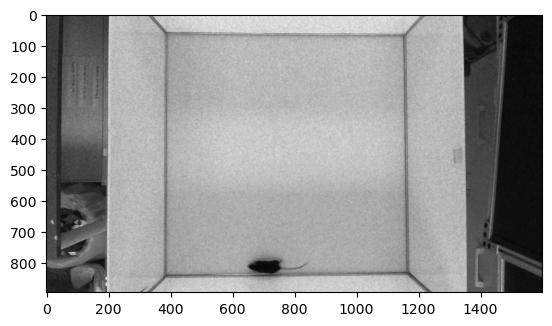

In [7]:
plt.imshow(grayscale_frames[2], cmap='gray')
plt.show()

In [9]:
#ce_frames = auto_contrast_adjustment(grayscale_frames)

Processing Frames: 100%|████████████████████████████████████████████████████████| 6965/6965 [05:21<00:00, 21.68frame/s]


In [34]:
#save_grayscale_movie(grayscale_frames, path_to_movie)
save_grayscale_movie_non_normalized(grayscale_frames, path_to_movie)

Saving Movie: 100%|█████████████████████████████████████████████████████████████████████| 6965/6965 [00:00<?, ?frame/s]

grayscale movie (grayscale, XVID compression) saved as: D:\JJM\OpenFieldData\06212023\CC02558091\_1\20230621-15-26-28_1_winvideo_c922_Pro_Stream_Webcam_3_python_grayscale_nn.mp4


True

In [8]:
ce_frames_hist  = auto_contrast_adjustment_eqhist(grayscale_frames)

Processing Frames: 100%|██████████████████████████████████████████████████████| 6965/6965 [00:05<00:00, 1289.53frame/s]


In [26]:
normalized_frames = save_contrast_enhanced_movie(ce_frames_hist, path_to_movie)

Saving Movie: 100%|████████████████████████████████████████████████████████████| 6965/6965 [00:37<00:00, 187.47frame/s]


Contrast-enhanced movie (grayscale, XVID compression) saved as: D:\JJM\OpenFieldData\06212023\CC02558091\_1\20230621-15-26-28_1_winvideo_c922_Pro_Stream_Webcam_3_python_ce_grayscale.mp4
